In [1]:

from datetime import datetime
import os
import os.path

import ruclip
from rudalle import get_rudalle_model, get_vae, get_tokenizer, get_realesrgan
from rudalle.pipelines import generate_images, show, cherry_pick_by_ruclip, super_resolution
from rudalle.utils import seed_everything
import torch
from translatepy import Translate

# Setting Arguments For Image Generation
Configuration Class:
```
save_path: The path to the checkpoint where the model was finetuned\
    example: /data/workspace_files/checkpoints
model_name: The name of the model check point that was finetuned
    example: tuned_model
num_picturs: The number of images to generate
    example: 6
output_image_path: Path to where output images should be saved
    example: '/data/workspace_files/output_images'
cache_dir: Path to the cached rudalle model
    example:'/data/workspace_files/rudalle'
```

In [2]:
class Args:
    def __init__(self):
        self.num_picturs = 6
        self.checkpoint_path = '/data/workspace/checkpoints'
        self.model_name = 'tuned_model'
        self.output_image_path = '/data/workspace/output_images'
        self.rudalle_cache_dir = '/data/workspace/rudalle'

def save_pil_images(pil_images):
    args = Args()
    current_time = datetime.now().strftime('%y-%m-%d_%H-%M-%S')
    for k in range(len(pil_images)):
        output_name = f"lg_{k}_{current_time}.png"
        pil_images[k].save(os.path.join(args.output_image_path, output_name))

# Initialize Model
- Set cache_dir to where rudalle model is held
- Set Initialize Translation Module
- Load vae 
- Set model to latest check-point

In [3]:
model_generation_args = Args()

translation_engine = Translate()

# Prepare model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device, cache_dir=model_generation_args.cache_dir)

vae = get_vae(dwt=True).to(device)

model_path = os.path.join(model_generation_args.save_path, f"{model_generation_args.model_name}_dalle_last.pt")

model.load_state_dict(torch.load(model_path))

tokenizer = get_tokenizer()

realesrgan = get_realesrgan('x2', device=device)

clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)

clip_predictor = ruclip.Predictor(clip, processor, device, bs=8)

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready
tokenizer --> ready
x2 --> ready


# Image Generation

This will initialize the clip predictor and prompt

In [4]:
seed_everything(42)

text_input = 'A red head woman named Laura'

print(f"Original Text: {text_input}")

text = translation_engine.translate(text_input, "ru").result
print(f"Translated Text: {text}")

pil_images = []
scores = []

for top_k, top_p, images_num in [
    (2048, 0.995, model_generation_args.num_picturs),
]:
    _pil_images, _scores = generate_images(text, tokenizer, model, vae, top_k=top_k, images_num=images_num, bs=8, top_p=top_p)
    pil_images += _pil_images
    scores += _scores

print(":: Image Generation Complete")

Original Text: A red head woman named Laura
Translated Text: Красная глава женщина по имени Лора
:: Image Generation Complete


/opt/python/envs/default/lib/python3.8/site-packages/rudalle/dalle/model.py:94: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row_ids = torch.arange(past_length, input_shape[-1] + past_length,


# Output 
Takes the generated images, produces high resolution versions and saves them to output


6it [00:00, 66.23it/s]


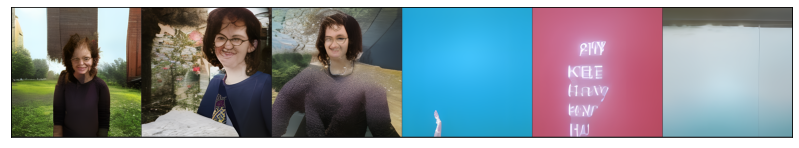

In [5]:
show(pil_images)

top_images, clip_scores = cherry_pick_by_ruclip(pil_images, text, clip_predictor, count=model_generation_args.num_picturs)
show(top_images, model_generation_args.num_picturs)

sr_images = super_resolution(top_images, realesrgan)
show(sr_images, model_generation_args.num_picturs)

save_pil_images(sr_images)